# Profit and Loss Historical Simulation

- Take the past 1 year worth of historical data,
- for each no-premium fee calculation (BSM, MC Normal, etc.),
- assume a 180 samples lookback fee calculation
- calculate the PnL of each period
- take a look at the Profit and Loss distribution and cummulative PnL over time
- evaluate the results
- compare with-fees vs no-fees

In [90]:

import math
import random as random

import pandas as pd

import numpy as np
from numpy.random import default_rng
np.set_printoptions(precision=5, suppress=True)

# fixes the seed for reproducibility
rng = default_rng(99)

import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy as scipy
from scipy.optimize import fsolve

import psycopg2

# import seaborn as sns

from math import log, sqrt, exp, pi
from scipy.stats import norm, laplace, t as student_t

# Markdown in code cell
from IPython.display import Markdown as md


plt.style.use('seaborn')
plt.colormaps
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'


# BSM Premium calculator
def bsm_premium(S0, K, T, sigma):
    # init
    r = 0.0
    # bsm terms
    d1 = (log(S0/K) + (r + 0.5 * sigma**2) * T) / sigma / sqrt(T)
    d2 = d1 - sigma * sqrt(T)
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    # bsm premium
    BSM_premium = S0 * N_d1 - K * exp(-r*T) * N_d2
    
    return BSM_premium

# BSM Fee calculator
def bsm_no_premium_call_option_fee(S0, T, sigma):
    # BSM no-premium option strike calculator
    def bsm_no_premium_strike(S0, T, sigma):
        # init
        r = 0.0
        K_at_money = S0
        # bsm terms
        d1 = (log(S0/K_at_money) + (r + 0.5 * sigma**2) * T) / sigma / sqrt(T)
        d2 = d1 - sigma * sqrt(T)
        N_d1 = norm.cdf(d1)
        N_d2 = norm.cdf(d2)
        
        def bsm_premium(K):
            # bsm premium
            BSM_C0_no_premium = S0 * N_d1 - K * exp(-r*T) * N_d2
            return BSM_C0_no_premium
        
        K_no_premium = fsolve(bsm_premium, K_at_money)[0]
        
        return K_no_premium

    K_no_premium = bsm_no_premium_strike(S0, T, sigma)

    fee = (K_no_premium-S0)/S0

    return fee

# MC Normal Fee calculator
def mc_no_premium_call_option_fee(S0, T, sigma, I):
    # MC no-premium option strike calculator
    def mc_no_premium_strike(S0, T, sigma, I):
        # init
        r = 0.0
        K_at_money = S0

        # underlying price vector at maturity
        mc_rng = default_rng(99)
        ST = S0 * np.exp((r - sigma ** 2 / 2) * T + sigma * math.sqrt(T) * mc_rng.standard_normal(I))

        def mc_premium(K):
            # not exercised
            CT_below_K_at_money = ST[ST <= K_at_money] * 0

            # exercised at a loss
            CT_below_K = ST[ST > K_at_money]
            CT_below_K = CT_below_K[CT_below_K <= K] - K

            # exercised at a gain
            CT_above_K = ST[ST > K] - K

            # call option payoff at maturity
            CT_no_premium = np.concatenate((CT_below_K_at_money, CT_below_K, CT_above_K))

            CT_no_premium_mean = CT_no_premium.mean()

            # call option fair value
            MC_C0_no_premium = math.exp(-r * T) * CT_no_premium_mean

            return MC_C0_no_premium
        
        K_no_premium = fsolve(mc_premium, K_at_money)[0]
        
        return K_no_premium

    K_no_premium = mc_no_premium_strike(S0, T, sigma, I)

    fee = (K_no_premium-S0)/S0

    return fee

# MC Laplace Fee calculator
def mc_laplace_no_premium_call_option_fee(S0, T, sample, I):
    # Fit the Laplace PDF.
    loc,scale = laplace.fit(sample)
    # MC Laplace no-premium option strike calculator
    def mc_laplace_no_premium_strike(S0, T, loc, scale, I):
        # init
        r = 0.0
        K_at_money = S0

        # underlying price vector at maturity
        mc_rng = default_rng(99)
        ST = S0 * np.exp(laplace.rvs(loc, scale, size=I, random_state=99))

        def mc_premium(K):
            # not exercised
            CT_below_K_at_money = ST[ST <= K_at_money] * 0

            # exercised at a loss
            CT_below_K = ST[ST > K_at_money]
            CT_below_K = CT_below_K[CT_below_K <= K] - K

            # exercised at a gain
            CT_above_K = ST[ST > K] - K

            # call option payoff at maturity
            CT_no_premium = np.concatenate((CT_below_K_at_money, CT_below_K, CT_above_K))

            CT_no_premium_mean = CT_no_premium.mean()

            # call option fair value
            MC_C0_no_premium = math.exp(-r * T) * CT_no_premium_mean

            return MC_C0_no_premium
        
        K_no_premium = fsolve(mc_premium, K_at_money)[0]
        
        return K_no_premium

    K_no_premium = mc_laplace_no_premium_strike(S0, T, loc, scale, I)

    fee = (K_no_premium-S0)/S0

    return fee

# MC Student's t Fee calculator
def mc_student_t_no_premium_call_option_fee(S0, T, sample, I):
    # Fit the Student's t PDF.
    df, tloc, tscale = student_t.fit(sample)
    # MC Student's t no-premium option strike calculator
    def mc_student_t_no_premium_strike(S0, T, df, tloc, tscale, I):
        # init
        r = 0.0
        K_at_money = S0

        # underlying price vector at maturity
        mc_rng = default_rng(99)
        ST = S0 * np.exp(student_t.rvs(df, tloc, tscale, size=I, random_state=99))

        def mc_premium(K):
            # not exercised
            CT_below_K_at_money = ST[ST <= K_at_money] * 0

            # exercised at a loss
            CT_below_K = ST[ST > K_at_money]
            CT_below_K = CT_below_K[CT_below_K <= K] - K

            # exercised at a gain
            CT_above_K = ST[ST > K] - K

            # call option payoff at maturity
            CT_no_premium = np.concatenate((CT_below_K_at_money, CT_below_K, CT_above_K))

            CT_no_premium_mean = CT_no_premium.mean()

            # call option fair value
            MC_C0_no_premium = math.exp(-r * T) * CT_no_premium_mean

            return MC_C0_no_premium
        
        K_no_premium = fsolve(mc_premium, K_at_money)[0]
        
        return K_no_premium

    K_no_premium = mc_student_t_no_premium_strike(S0, T, df, tloc, tscale, I)

    fee = (K_no_premium-S0)/S0

    return fee

# Data set
btcusd_1min = pd.read_csv("./BTCUSD.csv", sep=",", header=0, names=["date","open","high","low","close"], index_col="date")

# Using the past year only
# nb_2min_in_1y = 365*24*60
# ret_2min = btcusd_1min['ret_2min'][-nb_2min_in_1y:]
btcusd_1min = btcusd_1min.truncate(before='2021-05-31')

# calc 2min log-returns
btcusd_1min['ret_2min'] = np.log(btcusd_1min['close'] / btcusd_1min['close'].shift(2))
ret_2min = btcusd_1min['ret_2min']

# the 2-min vol
vol_2min = ret_2min.std()

# number of 2-minute per year
nb_2min_per_year = 60/2 * 24 * 365.25
vol_ann = vol_2min * sqrt(nb_2min_per_year)


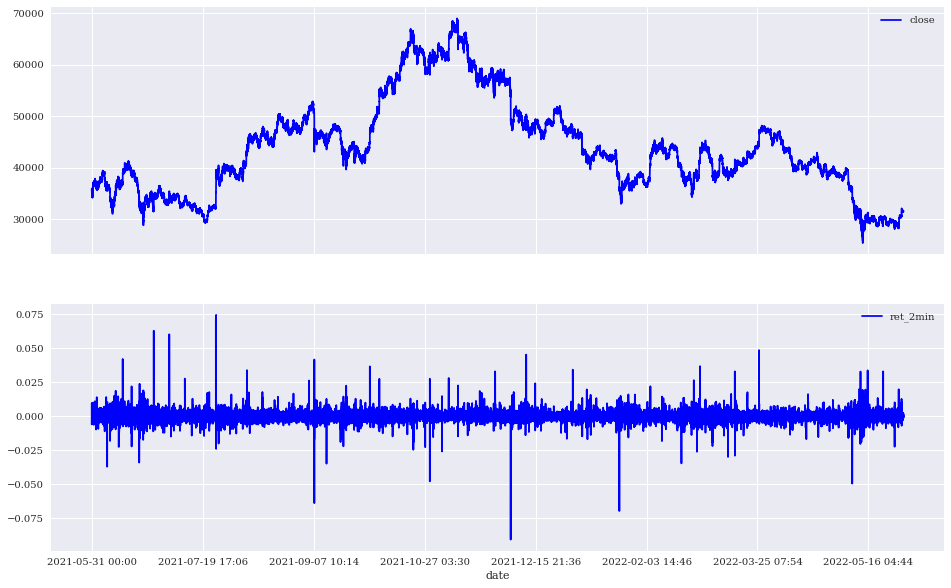

In [91]:

btcusd_1min[['close', 'ret_2min']].plot(subplots=True, style='b', figsize=(16, 10))

plt.show()

In [92]:

# risk free rate (no present value discounting)
r = 0.0

# 2min yearly fraction
T = 1 / (60/2 * 24 * 365.25)

# annualized 2min volatility
sigma = vol_ann

# number of price simulations
I = 1_000_000

# sample size
N = btcusd_1min['close'].size

header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|T|{float('%.3g' % T)}|\n"
table += f"|r|{r}|\n"
table += f"|σ|{float('%.5g' % (sigma*100))}%|\n"
table += f"|I|{I}|\n"

table2 = ""
table2 += f"|Samples| past 1 year|\n"
table2 += f"|N|{N}|\n"

md(f"""### Simulation variables
{header}
{table}
{header}
{table2}
""")


### Simulation variables
|variable|value|
|:-:|-:|
|T|3.8e-06|
|r|0.0|
|σ|81.486%|
|I|1000000|

|variable|value|
|:-:|-:|
|Samples| past 1 year|
|N|365779|



In [94]:


header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|σ|{float('%.5g' % (sigma*100))}%|\n"

table2 = ""
table2 += f"|S(0)|{float('%.8g' % S0)} USD|\n"
table2 += f"|BSM strike|{float('%.7g' % bsm_strike)} USD|\n"
table2 += f"|MC Normal strike|{float('%.7g' % mc_normal_strike)} USD|\n"
table2 += f"|MC Laplace strike|{float('%.7g' % mc_laplace_strike)} USD|\n"
table2 += f"|MC Student's t strike|{float('%.7g' % mc_student_t_strike)} USD|\n"

table3 = ""
table3 += f"|BSM fee|{float('%.5g' % (bsm_fee*100))}%|\n"
table3 += f"|MC Normal fee|{float('%.5g' % (mc_normal_fee*100))}%|\n"
table3 += f"|MC Laplace fee|{float('%.5g' % (mc_laplace_fee*100))}%|\n"
table3 += f"|MC Student's t fee|{float('%.5g' % (mc_student_t_fee*100))}%|\n"

table4 = ""
table4 += f"|BSM PnL|{float('%.7g' % bsm_pnl)} USD|\n"
table4 += f"|MC Normal PnL|{float('%.7g' % mc_normal_pnl)} USD|\n"
table4 += f"|MC Laplace PnL|{float('%.7g' % mc_laplace_pnl)} USD|\n"
table4 += f"|MC Student's t PnL|{float('%.7g' % mc_student_t_pnl)} USD|\n"

table5 = ""
table5 += f"|BSM premuim|{float('%.4g' % bsm_c0)} USD|\n"

md(f"""### Data fitting stats
{header}
{table}
### At-the-money Premium
{header}
{table5}
### Calculated Strikes
{header}
{table2}
### Calculated Fees
{header}
{table3}
### Calculated PnLs
{header}
{table4}
""")


### Data fitting stats
|variable|value|
|:-:|-:|
|σ|81.486%|

### At-the-money Premium
|variable|value|
|:-:|-:|
|BSM premuim|8.702 USD|

### Calculated Strikes
|variable|value|
|:-:|-:|
|S(0)|31605.2 USD|
|BSM strike|31622.61 USD|
|MC Normal strike|31622.61 USD|
|MC Laplace strike|31621.59 USD|
|MC Student's t strike|31625.72 USD|

### Calculated Fees
|variable|value|
|:-:|-:|
|BSM fee|0.055081%|
|MC Normal fee|0.05508%|
|MC Laplace fee|0.051873%|
|MC Student's t fee|0.064923%|

### Calculated PnLs
|variable|value|
|:-:|-:|
|BSM PnL|79.60847 USD|
|MC Normal PnL|79.60818 USD|
|MC Laplace PnL|78.59448 USD|
|MC Student's t PnL|82.719 USD|



In [108]:
# define historical simulation per iteration task

# bootstrap per iteration task
def historical_simulation(i, N_lookback):
    # indices
    curr_idx = -i
    look_idx = -i - N_lookback

    # lookback array to extract stats from
    lookback = btcusd_1min['ret_2min'][look_idx:curr_idx]

    # underlying price at t=0
    S0 = btcusd_1min['close'][curr_idx]
    
    # print(f'lookback = {lookback}')
    # print(f'curr_idx = {curr_idx}')
    # print(f'look_idx = {look_idx}')
    # print(f'lookback.size = {lookback.size}')
    # print(f'S0 = {S0}')

    # BSM volatility
    vol_2min = lookback.std()
    vol_ann = vol_2min * sqrt(nb_2min_per_year)
    sigma = vol_ann

    # print(f'vol_2min = {vol_2min}')
    # print(f'nb_2min_per_year = {nb_2min_per_year}')
    # print(f'vol_ann = {vol_ann}')


    # calc bsm at the money premium
    bsm_c0 = bsm_premium(S0, S0, T, sigma)
    btcusd_1min['bsm_c0'][curr_idx] = bsm_c0

    # calc bsm fee
    bsm_fee = bsm_no_premium_call_option_fee(S0, T, sigma)
    # calc bsm strike
    bsm_strike = S0 * (1 + bsm_fee)
    btcusd_1min['bsm_strike'][curr_idx] = bsm_strike

    # calc mc normal fee
    mc_normal_fee = mc_no_premium_call_option_fee(S0, T, sigma, I)
    # calc mc normal strike
    mc_normal_strike = S0 * (1 + mc_normal_fee)
    btcusd_1min['mc_normal_strike'][curr_idx] = mc_normal_strike

    # calc mc laplace fee
    mc_laplace_fee = mc_laplace_no_premium_call_option_fee(S0, T, lookback, I)
    # calc mc laplace strike
    mc_laplace_strike = S0 * (1 + mc_laplace_fee)
    btcusd_1min['mc_laplace_strike'][curr_idx] = mc_laplace_strike

    # calc mc student's t fee
    mc_student_t_fee = mc_student_t_no_premium_call_option_fee(S0, T, lookback, I)
    # calc mc student's t strike
    mc_student_t_strike = S0 * (1 + mc_student_t_fee)
    btcusd_1min['mc_student_t_strike'][curr_idx] = mc_student_t_strike




In [109]:
# parallelize bootstrap loop

from joblib import Parallel, delayed
import multiprocessing

# stats inference window
N_lookback = 180
# N = btcusd_1min['close'].size
N = btcusd_1min['close'].size - N_lookback - 2
# N = 2
# N = 365500

print(N)

# init new colums
btcusd_1min['bsm_c0'] = 0.
btcusd_1min['bsm_strike'] = 0.
btcusd_1min['mc_normal_strike'] = 0.
btcusd_1min['mc_laplace_strike'] = 0.
btcusd_1min['mc_student_t_strike'] = 0.

# parallel historical simulation starting from ~ 1y ago
num_cores = multiprocessing.cpu_count()
void = Parallel(n_jobs=(num_cores-1), require='sharedmem')(delayed(historical_simulation)(i, N_lookback) for i in range(N, 0,-1))

# btcusd_1min

365597


/home/sebver/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


,open,high,low,close,ret_2min,bsm_c0,bsm_strike,mc_normal_strike,mc_laplace_strike,mc_student_t_strike
date,,,,,,,,,,
2021-05-31 00:00,35706.8,35706.8,35652.5,35669.4,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
2021-05-31 00:01,35669.4,35669.4,35542.2,35545.3,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
2021-05-31 00:02,35541.9,35576.0,35412.5,35462.7,-0.005812,0.000000,0.000000,0.000000,0.000000,0.000000
2021-05-31 00:03,35462.7,35560.9,35446.8,35527.8,-0.000492,0.000000,0.000000,0.000000,0.000000,0.000000
2021-05-31 00:04,35527.8,35540.1,35492.3,35524.0,0.001727,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2022-05-31 10:32,31599.1,31599.1,31599.1,31599.1,0.000000,8.691974,31616.488731,31616.488438,31615.479995,31619.530627
2022-05-31 10:33,31599.1,31599.1,31599.1,31599.1,0.000000,8.691614,31616.488011,31616.487719,31615.459575,31619.524737
2022-05-31 10:34,31607.3,31618.1,31607.3,31614.7,0.000494,8.694349,31632.093481,31632.093190,31631.039325,31635.096969


In [194]:
# calc pnl

# init
btcusd_1min['no_fee_pnl'] = 0.
btcusd_1min['10bps_fee_pnl'] = 0.
btcusd_1min['bsm_pnl'] = 0.
btcusd_1min['mc_normal_pnl'] = 0.
btcusd_1min['mc_laplace_pnl'] = 0.
btcusd_1min['mc_student_t_pnl'] = 0.

# S0 / ST
btcusd_1min['S0'] = btcusd_1min['close']
S0 = btcusd_1min['S0']
btcusd_1min['ST'] = btcusd_1min['close'].shift(-2)
ST = btcusd_1min['ST']

# calc no-fee pnl
# btcusd_1min['no_fee_pnl'] = S0 - ST
btcusd_1min['no_fee_pnl'] = -np.maximum(ST - S0, 0)

# calc 10bps-fee pnl
btcusd_1min['10bps_fee_pnl'][ST > S0] = S0*(1+0.0010) - ST

# calc bsm pnl
btcusd_1min['bsm_pnl'] = btcusd_1min['bsm_strike'] - ST

# calc mc normal pnl
btcusd_1min['mc_normal_pnl'] = btcusd_1min['mc_normal_strike'] - ST

# calc mc laplace pnl
btcusd_1min['mc_laplace_pnl'] = btcusd_1min['mc_laplace_strike'] - ST

# calc mc student's t pnl
btcusd_1min['mc_student_t_pnl'] = btcusd_1min['mc_student_t_strike'] - ST

# smooth student's t due infinite variance
btcusd_1min['mc_student_t_strike'][btcusd_1min['mc_student_t_strike'] > 2*btcusd_1min['bsm_strike'].median()] = np.NaN
btcusd_1min['mc_student_t_strike'][btcusd_1min['mc_student_t_strike'] < 0] = np.NaN

# [btcusd_1min['close'],ST]
# btcusd_1min

In [195]:
# take a look at the pnl
btcusd_1min[['S0', 'ST', 'no_fee_pnl', '10bps_fee_pnl', 'bsm_pnl', 'mc_normal_pnl', 'mc_laplace_pnl', 'mc_student_t_pnl']][N_lookback + 2:-2]


,S0,ST,no_fee_pnl,10bps_fee_pnl,bsm_pnl,mc_normal_pnl,mc_laplace_pnl,mc_student_t_pnl
date,,,,,,,,
2021-05-31 03:03,34574.2,34497.6,-0.0,0.0000,135.367307,135.365000,129.064907,138.691501
2021-05-31 03:04,34478.9,34430.1,-0.0,0.0000,106.609915,106.607156,100.622665,110.487539
2021-05-31 03:05,34497.6,34430.4,-0.0,0.0000,125.712073,125.709648,119.841756,129.864766
2021-05-31 03:06,34430.1,34468.2,-38.1,-3.6699,20.276747,20.274345,14.450095,24.296246
2021-05-31 03:07,34430.4,34430.3,-0.0,0.0000,54.644013,54.641420,50.932342,61.645390
...,...,...,...,...,...,...,...,...
2022-05-31 10:30,31599.1,31599.1,-0.0,0.0000,17.419849,17.419548,16.647978,20.644858
2022-05-31 10:31,31599.1,31599.1,-0.0,0.0000,17.402366,17.402070,16.502549,20.523129
2022-05-31 10:32,31599.1,31614.7,-15.6,15.9991,1.788731,1.788438,0.779995,4.830627


In [196]:
btcusd_1min[['S0', 'ST', 'bsm_c0', 'bsm_strike', 'bsm_pnl', 'no_fee_pnl', '10bps_fee_pnl']][N_lookback + 2:-2]


,S0,ST,bsm_c0,bsm_strike,bsm_pnl,no_fee_pnl,10bps_fee_pnl
date,,,,,,,
2021-05-31 03:03,34574.2,34497.6,29.358702,34632.967307,135.367307,-0.0,0.0000
2021-05-31 03:04,34478.9,34430.1,28.880746,34536.709915,106.609915,-0.0,0.0000
2021-05-31 03:05,34497.6,34430.4,29.231246,34556.112073,125.712073,-0.0,0.0000
2021-05-31 03:06,34430.1,34468.2,29.163650,34488.476747,20.276747,-38.1,-3.6699
2021-05-31 03:07,34430.4,34430.3,27.250422,34484.944013,54.644013,-0.0,0.0000
...,...,...,...,...,...,...,...
2022-05-31 10:30,31599.1,31599.1,8.707525,31616.519849,17.419849,-0.0,0.0000
2022-05-31 10:31,31599.1,31599.1,8.698788,31616.502366,17.402366,-0.0,0.0000
2022-05-31 10:32,31599.1,31614.7,8.691974,31616.488731,1.788731,-15.6,15.9991


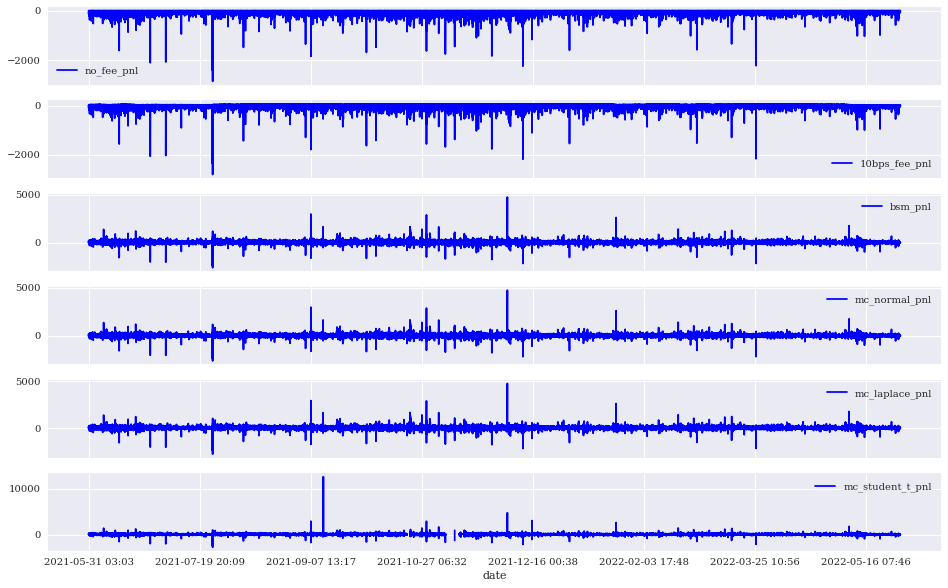

In [197]:
# take a look at the pnl

# btcusd_1min[['bsm_c0', 'bsm_strike', 'mc_normal_strike', 'mc_laplace_strike', 'mc_student_t_strike']][N_lookback + 2:-2].plot(subplots=True, style='b', figsize=(16, 10))
# btcusd_1min[['mc_student_t_strike']].plot(subplots=True, style='b', figsize=(16, 10))
# btcusd_1min[['mc_student_t_strike']].plot(subplots=True, style='b', figsize=(16, 10), logy=True)
# btcusd_1min[['mc_student_t_strike']].plot(subplots=True, style='b', figsize=(16, 10))
# btcusd_1min[['mc_student_t_strike']][N_lookback + 2:-2].plot(subplots=True, style='b', figsize=(16, 10))
# btcusd_1min[['bsm_pnl', 'mc_normal_pnl', 'mc_laplace_pnl', 'mc_student_t_pnl']][N_lookback + 2:-2].plot(subplots=True, style='b', figsize=(16, 10))
btcusd_1min[['no_fee_pnl', '10bps_fee_pnl', 'bsm_pnl', 'mc_normal_pnl', 'mc_laplace_pnl', 'mc_student_t_pnl']][N_lookback + 2:-2].plot(subplots=True, style='b', figsize=(16, 10))

plt.show()

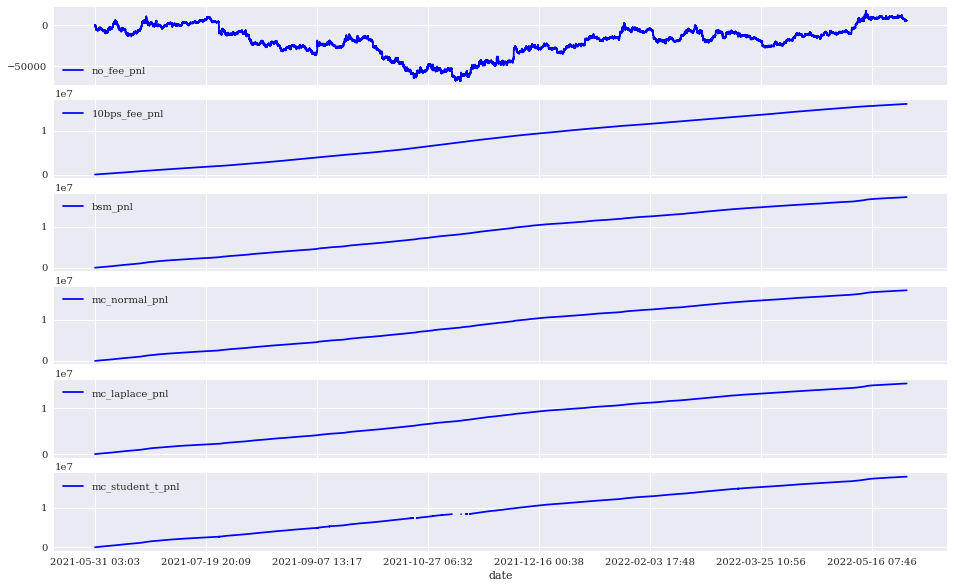

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

In [193]:
# cummulative sum the pnl

btcusd_1min[['no_fee_pnl', '10bps_fee_pnl', 'bsm_pnl', 'mc_normal_pnl', 'mc_laplace_pnl', 'mc_student_t_pnl']][N_lookback + 2:-2].cumsum().plot(subplots=True, style='b', figsize=(16, 10))

# [
#     btcusd_1min[['bsm_pnl', 'mc_normal_pnl', 'mc_laplace_pnl', 'mc_student_t_pnl']][N_lookback + 2:-2].cumsum()
# ]


In [161]:

# btcusd_1min[['bsm_pnl', 'mc_normal_pnl', 'mc_laplace_pnl']]
# btcusd_1min[['bsm_pnl', 'mc_normal_pnl', 'mc_laplace_pnl', 'mc_student_t_pnl', 'mc_student_t_strike', 'close']].tail(50)
# btcusd_1min['mc_student_t_pnl'].tail(50)

[
    # btcusd_1min['mc_student_t_strike'].mean(),
    # btcusd_1min['mc_student_t_strike'].median(),
    # btcusd_1min['mc_student_t_strike'],
    # btcusd_1min['mc_student_t_strike'][btcusd_1min['mc_student_t_strike']>2*btcusd_1min['mc_student_t_strike'].median()],
    # btcusd_1min['mc_student_t_strike'][btcusd_1min['mc_student_t_strike']>1.1*btcusd_1min['close'].max()],
    # btcusd_1min['bsm_strike'][btcusd_1min['bsm_strike']<0],
    # btcusd_1min['mc_normal_strike'][btcusd_1min['mc_normal_strike']<0],
    # btcusd_1min['mc_laplace_strike'][btcusd_1min['mc_laplace_strike']<0],
    # btcusd_1min['mc_student_t_strike'][btcusd_1min['mc_student_t_strike']<0],
    # btcusd_1min[['bsm_strike', 'mc_normal_strike', 'mc_laplace_strike', 'mc_student_t_strike']][btcusd_1min['mc_student_t_strike']<0],
]

[]

In [111]:
# back up calcs

# btcusd_1min.to_csv('btcusd_1min_with_trikes.csv')
# btcusd_1min.to_csv('btcusd_1min_with_all.csv')